# Imports

In [9]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [10]:
# plot styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.2)

# Data & Setup

In [11]:
data_dir = "../data/raw/Task07_Pancreas/imagesTr"
label_dir = "../data/raw/Task07_Pancreas/labelsTr"

In [12]:
# first sample
sample_filename = "pancreas_001.nii.gz"
img = nib.load(os.path.join(data_dir, sample_filename)) # lazy loading
label = nib.load(os.path.join(label_dir, sample_filename)) # lazy loading
# to numpy 
image_data = img.get_fdata() 
label_data = label.get_fdata()
# metadata
header = img.header
spacing = header.get_zooms()

# PCA on patches

idea:
- patch extraction
- PCA on patches

[*] Processing 4000 samples...


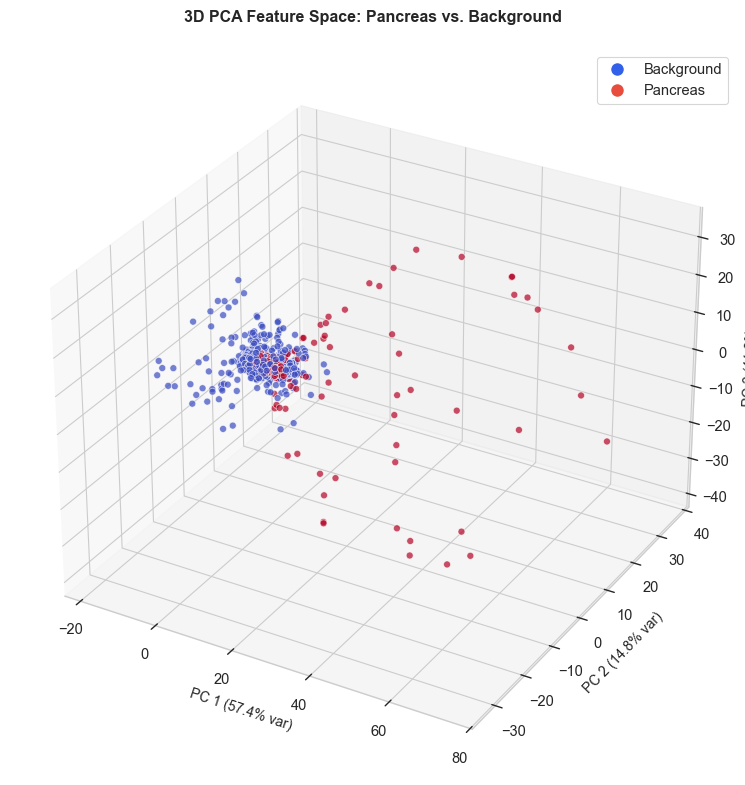

--- PCA Metrics ---
Explained Variance Ratio: PC1=0.5741, PC2=0.1480, PC3=0.1133
Cumulative Variance (3 PCs): 0.8354


In [14]:
def analyze_feature_space_3d(image_data, label_data, n_samples=1000, patch_size=5):
    """
    Extracts texture patches and projects them into 3D using PCA (SVD).
    Visualizes the distribution of classes in the latent feature space.
    """
    pad = patch_size // 2
    
    # 1. Identify Foreground (Pancreas) and relevant Background
    fg_coords = np.argwhere(label_data > 0)
    bg_coords = np.argwhere((label_data == 0) & (image_data > -100) & (image_data < 200))
    
    n_fg = min(len(fg_coords), n_samples)
    n_bg = min(len(bg_coords), n_samples)
    
    # Random sampling for a balanced view
    fg_indices = fg_coords[np.random.choice(len(fg_coords), n_fg, replace=False)]
    bg_indices = bg_coords[np.random.choice(len(bg_coords), n_bg, replace=False)]
    
    patches = []
    labels = [] 
    
    print(f"[*] Processing {n_fg + n_bg} samples...")
    
    for coord in np.vstack([fg_indices, bg_indices]):
        x, y, z = coord
        if x < pad or x >= image_data.shape[0]-pad or y < pad or y >= image_data.shape[1]-pad:
            continue
            
        patch = image_data[x-pad:x+pad+1, y-pad:y+pad+1, z]
        patches.append(patch.flatten())
        labels.append(1 if len(labels) < n_fg else 0)
        
    X = np.array(patches)
    y = np.array(labels)
    
    # 2. Standardization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 3. PCA Calculation
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X_scaled)
    var = pca.explained_variance_ratio_
    
    # --- VISUALIZATION ---
    # Focused 3D Scatter Plot
    fig = plt.figure(figsize=(10, 8), facecolor='white')
    ax = fig.add_subplot(111, projection='3d')
    
    # Scatter plot with high-quality styling
    scatter = ax.scatter(
        X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
        c=y, cmap='coolwarm', alpha=0.7, s=25, edgecolor='w', linewidth=0.5
    )
    
    # Labels with Explained Variance
    ax.set_xlabel(f"PC 1 ({var[0]:.1%} var)", fontsize=10)
    ax.set_ylabel(f"PC 2 ({var[1]:.1%} var)", fontsize=10)
    ax.set_zlabel(f"PC 3 ({var[2]:.1%} var)", fontsize=10)
    ax.set_title("3D PCA Feature Space: Pancreas vs. Background", fontweight='bold', pad=20)
    
    # Clean Legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#3360e8', label='Background', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#e74c3c', label='Pancreas', markersize=10)
    ]
    ax.legend(handles=legend_elements, loc='upper right', frameon=True)
    
    plt.tight_layout()
    plt.show()
    
    # Print metrics for your Markdown interpretation
    print(f"--- PCA Metrics ---")
    print(f"Explained Variance Ratio: PC1={var[0]:.4f}, PC2={var[1]:.4f}, PC3={var[2]:.4f}")
    print(f"Cumulative Variance (3 PCs): {np.sum(var):.4f}")

# Execute
analyze_feature_space_3d(image_data, label_data, n_samples=2000, patch_size=7)

interpretation:
- PC1: ~57% -> most likely intensity difference
- PC2 & PC3: ~26% -> most likely texture & co
- BUT: high overlap -> 83% information not enough to separation/ segmentation -> more complex architectures